## Dependencias

In [1]:
import numpy as np
import pandas as pd

import datetime as dt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer

from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf

cf.go_offline()

## Lectura de datos

In [2]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/medidas amv.csv'

In [3]:
df = pd.read_csv(ruta)
df.head()

,Marca temporal,Edad (Años),Estatura (cm),Peso (Kg),"# de Zapato (23,24,25, 25.5, ..., etc)",Sexo
0,2022/02/15 6:31:48 p. m. GMT-6,21,163.0,65.0,24.5,Mujer
1,2022/02/15 6:31:51 p. m. GMT-6,21,180.0,70.0,28.0,Hombre
2,2022/02/15 6:31:55 p. m. GMT-6,22,180.0,80.0,28.5,Hombre
3,2022/02/15 6:31:55 p. m. GMT-6,21,180.0,83.0,29.0,Hombre
4,2022/02/15 6:31:56 p. m. GMT-6,23,178.0,67.0,27.5,Hombre


In [4]:
df.shape

(63, 6)

### Cambio de nombre de columna

In [5]:
df.rename(columns = {'# de Zapato (23,24,25, 25.5, ..., etc)': '# de Zapato'}, inplace= True)

## Derfinición de variables

In [6]:
vart = ['Sexo']
var = [v for v in df.columns if df[v].dtype != 'object']

## Análisis exploratorio

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Marca temporal  63 non-null     object 
 1   Edad (Años)     63 non-null     int64  
 2   Estatura (cm)   63 non-null     float64
 3   Peso (Kg)       63 non-null     float64
 4   # de Zapato     63 non-null     float64
 5   Sexo            63 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 3.1+ KB


### Valores nulos

In [8]:
fuera  = 1 - df[var].describe().T[['count']]/len(df)
fuera

,count
Edad (Años),0.0
Estatura (cm),0.0
Peso (Kg),0.0
# de Zapato,0.0


### Varianza nula

In [9]:
vt = VarianceThreshold()
vt.fit(df[var])

VarianceThreshold()

In [10]:
fuera = [a for a,b in zip(var, vt.get_support()) if not b]
fuera

[]

In [11]:
Xi = df[var].copy()

In [12]:
Xi.drop(fuera, axis = 1, inplace=True)
Xi.shape

(63, 4)

### Slección de variables con mayor poder predictivo

In [13]:
sk = SelectKBest(k = 3)
sk.fit(Xi, df[vart[0]])

SelectKBest(k=3)

In [14]:
fuera = [a for a,b in zip(var, sk.get_support()) if not b]
var = [v for v in var if v not in fuera]
Xi.drop(fuera, axis = 1, inplace = True)

In [15]:
aux = pd.DataFrame(zip(var, sk.scores_), columns=['var', 'score']).set_index('var').sort_values(by = 'score',
                            ascending = False)
aux = aux[aux.index.isin(var)]
aux.iplot(kind = 'bar', color = 'purple')

### Extremos

In [16]:
Xi.shape

(63, 3)

array([[<AxesSubplot:title={'center':'Estatura (cm)'}>,
        <AxesSubplot:title={'center':'Peso (Kg)'}>],
       [<AxesSubplot:title={'center':'# de Zapato'}>, <AxesSubplot:>]],
      dtype=object)

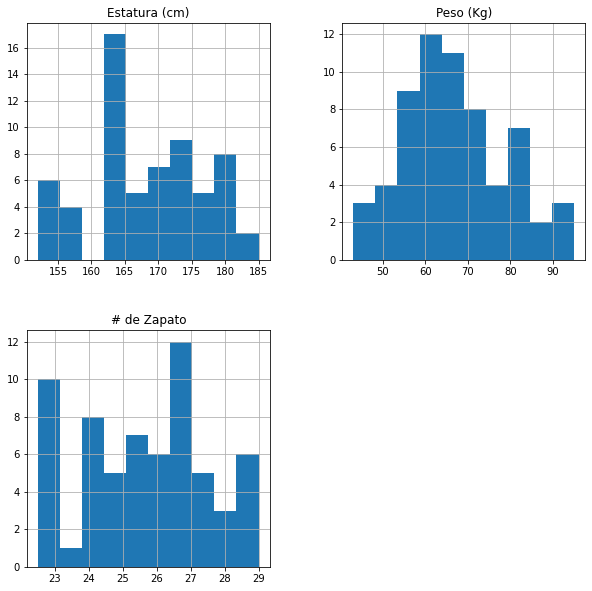

In [17]:
Xi[var].hist(figsize = (10,10))

In [18]:
for v,li,ls in Xi[var].describe(percentiles = [0.01, 0.99]).T[['1%', '99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like = 'ex_').max(axis = 1)

In [19]:
Xi['ex_'].value_counts(1)

0    0.952381
1    0.047619
Name: ex_, dtype: float64

In [20]:
Xi[vart] = df[vart]

In [21]:
Xi = Xi.loc[Xi['ex_'] == 0].reset_index(drop= True).drop(Xi.filter(like = 'ex_').columns, axis = 1)

In [22]:
Xi.head()

,Estatura (cm),Peso (Kg),# de Zapato,Sexo
0,163.0,65.0,24.5,Mujer
1,180.0,70.0,28.0,Hombre
2,180.0,80.0,28.5,Hombre
3,180.0,83.0,29.0,Hombre
4,178.0,67.0,27.5,Hombre


array([[<AxesSubplot:title={'center':'Estatura (cm)'}>,
        <AxesSubplot:title={'center':'Peso (Kg)'}>],
       [<AxesSubplot:title={'center':'# de Zapato'}>, <AxesSubplot:>]],
      dtype=object)

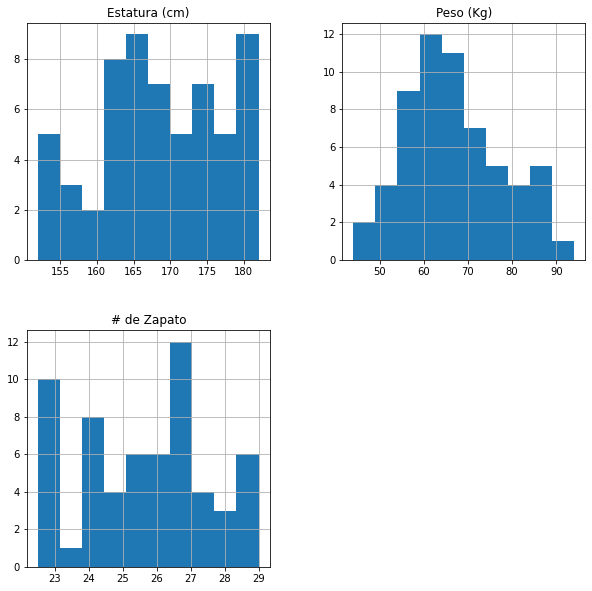

In [23]:
Xi[var].hist(figsize = (10,10))

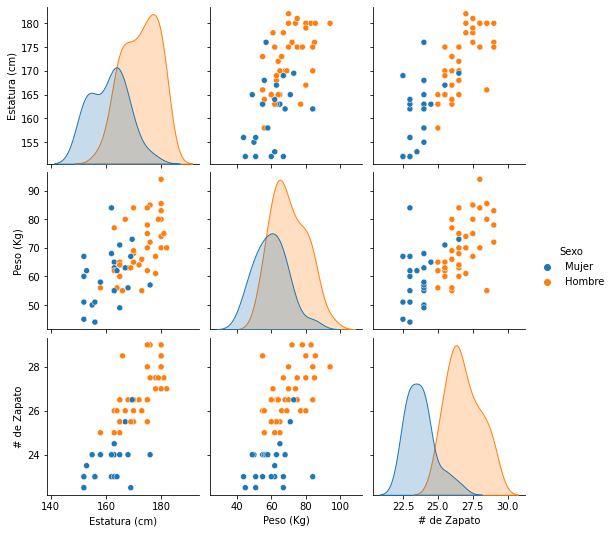

In [24]:
sns.pairplot(data=Xi[var + vart], hue= vart[0])

## Cambio de espacio $\mathcal{X}_{[0,1]}$

In [25]:
sc = MinMaxScaler()
sc.fit(Xi[var])

MinMaxScaler()

In [26]:
X01 = pd.DataFrame(sc.transform(Xi[var]), columns= var)
X01[vart] = Xi[vart]

## Partición

In [27]:
Xt,Xv,yt,yv = train_test_split(X01[var], X01[vart[0]], train_size=0.7)
Xt.reset_index(drop = True, inplace=True)
Xv.reset_index(drop = True, inplace=True)
yv.reset_index(drop = True, inplace=True)
yt.reset_index(drop = True, inplace=True)

## Aprendizaje

### Hiperparametrización

In [28]:
hp = dict(C = np.arange(0.1,2,0.1),
         kernel = ['linear', 'poly', 'rbf', 'sigmoid'],
         degree = range(2,3),
          probability = [True])

In [29]:
reduce(lambda x,y:x*y,[len(y) for x,y in hp.items()])

76

In [30]:
modelo = SVC()

In [31]:
grid = RandomizedSearchCV(param_distributions=hp,
                         n_iter= 100,
                         cv = 5,
                         scoring= 'accuracy',
                         n_jobs=-1,
                         verbose=True,
                         estimator = modelo)

In [32]:
grid.fit(Xt, yt)

Fitting 5 folds for each of 76 candidates, totalling 380 fits


/home/oscarjarillo/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning:

The total space of parameters 76 is smaller than n_iter=100. Running 76 iterations. For exhaustive searches, use GridSearchCV.



RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'degree': range(2, 3),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True]},
                   scoring='accuracy', verbose=True)

In [33]:
grid.best_params_

{'probability': True, 'kernel': 'linear', 'degree': 2, 'C': 0.5}

In [34]:
modelo = grid.best_estimator_
modelo

SVC(C=0.5, degree=2, kernel='linear', probability=True)

### Búsqueda de parámetros 

In [35]:
modelo.fit(Xt, yt)

SVC(C=0.5, degree=2, kernel='linear', probability=True)

## Validación del modelo

In [36]:
print(accuracy_score(y_pred= modelo.predict(Xt), y_true = yt))
print(accuracy_score(y_pred= modelo.predict(Xv), y_true = yv))

0.9523809523809523
0.8333333333333334


In [37]:
print(confusion_matrix(y_pred= modelo.predict(Xt), y_true = yt))
print(confusion_matrix(y_pred= modelo.predict(Xv), y_true = yv))

[[24  1]
 [ 1 16]]
[[12  0]
 [ 3  3]]
